# Step 1: Scraping Data:

In [10]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

api_key = 'A813C919-1F64-4863-94B9-2A4477F8EEFA'  #uses api key to get access

symbols = ['COINBASE_SPOT_BTC_USD', 'COINBASE_SPOT_ETH_USD', 'COINBASE_SPOT_XRP_USD'] #data to be extracted
period_id = '1DAY'
headers = {
    'X-CoinAPI-Key': api_key
}

def Data_extraction(symbol_id, filePath):
    try:
        url = f'https://rest.coinapi.io/v1/ohlcv/{symbol_id}/history?period_id={period_id}' ## URL TO COINAPI WEBSITE
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            data = response.json()
            relevant_columns = ['time_period_start', 'price_open', 'price_high', 'price_low', 'price_close', 'volume_traded']#COLS TO GET

            #trong in DataFrame with relevant columns
            df = pd.DataFrame(data)[relevant_columns]

            # saving in csv file
            df.to_csv(filePath, index=False)
            
            
            print(f"Data for {symbol_id} successfully written to {filePath}")

        else:
            print(f"Failed to retrieve data for {symbol_id}. Status code: {response.status_code}")

    except Exception as e:
        print(f"An error occurred for {symbol_id}: {e}")

for symbol_id in symbols:
    Data_extraction(symbol_id, f'{symbol_id}_data.csv')

Data for COINBASE_SPOT_BTC_USD successfully written to COINBASE_SPOT_BTC_USD_data.csv
Data for COINBASE_SPOT_ETH_USD successfully written to COINBASE_SPOT_ETH_USD_data.csv
Data for COINBASE_SPOT_XRP_USD successfully written to COINBASE_SPOT_XRP_USD_data.csv


# Step 2: Data Cleaning and Structuring

# Step 3: Handling Missing Values

In [4]:

class DataCleaning:
    def __init__(self, data):
        self.data = data
        self.cleanData()

    def cleanData(self):
        
        # Convert timestamps to datetime objects
        self.data['time_period_start'] = pd.to_datetime(self.data['time_period_start'])
        
        #fills missing values with the closest Available value
        self.data.ffill(inplace=True)
        self.data.bfill(inplace=True)
        
        numericCol = self.data.select_dtypes(include='number').columns
        
        self.data[numericCol] = self.data[numericCol].fillna(self.data[numericCol].mean())
        
    def removeOutliers(self):
        conditions = (self.data['price_open'] >= 0) & (self.data['price_high'] >= 0) & (self.data['price_low'] >= 0) & (self.data['price_close'] >= 0)
        self.data = self.data[conditions]
    
    def logReturns(self):
        
        self.data['time_period_start'] = pd.to_datetime(self.data['time_period_start'])
        self.data.fillna(method='ffill',inplace=True)
        self.data.sort_values(by='time_period_start', inplace=True)
        self.data['log_returns'] = np.log(self.data['price_close'] / self.data['price_close'].shift(1))
    
    def structure_data(self):
        self.data['daily_price_change'] = self.data['close_price'] - self.data['open_price']


btc_csv='COINBASE_SPOT_BTC_USD_data.csv'
eth_csv='COINBASE_SPOT_ETH_USD_data.csv'
xrp_csv='COINBASE_SPOT_XRP_USD_data.csv'

# reads the csv file
btc_data = pd.read_csv(btc_csv)
eth_data = pd.read_csv(eth_csv)
xrp_data = pd.read_csv(xrp_csv)

# objects
btc_Obj = DataCleaning(btc_data)
eth_Obj = DataCleaning(eth_data)
xrp_Obj = DataCleaning(xrp_data)

btc_Obj.cleanData()
eth_Obj.cleanData()
xrp_Obj.cleanData()

# Calculate log returns
btc_Obj.logReturns()
eth_Obj.logReturns()
xrp_Obj.logReturns()

btc_Obj.removeOutliers()
eth_Obj.removeOutliers()
xrp_Obj.removeOutliers()

print(btc_data)
print(eth_data)
print(xrp_data)

           time_period_start  price_open  price_high  price_low  price_close  \
99 2023-08-28 00:00:00+00:00    26091.16    26232.88   25850.00     26101.04   
98 2023-08-29 00:00:00+00:00    26101.03    28184.89   25903.18     27717.98   
97 2023-08-30 00:00:00+00:00    27717.15    27775.00   27015.75     27306.06   
96 2023-08-31 00:00:00+00:00    27306.06    27576.99   25660.61     25932.45   
95 2023-09-01 00:00:00+00:00    25931.51    26142.28   25307.37     25794.88   
..                       ...         ...         ...        ...          ...   
4  2023-12-01 00:00:00+00:00    37732.27    39000.00   37618.25     38703.54   
3  2023-12-02 00:00:00+00:00    38706.55    39740.00   38660.03     39478.95   
2  2023-12-03 00:00:00+00:00    39467.42    40221.22   39293.02     39984.81   
1  2023-12-04 00:00:00+00:00    39984.81    42410.46   39983.60     41987.24   
0  2023-12-05 00:00:00+00:00    41930.01    44224.58   41384.03     44153.44   

    volume_traded  log_returns  
99    

# Step 4: Data Transformation


# Step 5: Analysis

In [5]:
class DataAnalysis:
    def __init__(self,obj, name):
        self.Obj = obj
        self.name = name

    def calculateReturns(self):
        return self.Obj.data['log_returns']

    def mean(self):
        return self.calculateReturns().mean()

    def median(self):
        return self.calculateReturns().median()

    def STD(self):
        return self.calculateReturns().std()

    def highestReturn(self):
        max_return = self.Obj.data.loc[self.calculateReturns().idxmax(), 'time_period_start']
        return max_return

    def previousData(self):
        return self.Obj.data['time_period_start'], self.Obj.data['price_close']

    def print_analysis(self):
        print(f"{self.name} ANALYSIS:")
        print(f"Mean Return: {self.mean()}")
        print(f"Median Return: {self.median()}")
        print(f"Standard Deviation of Returns: {self.STD()}")
        print(f"Date with Highest Return: {self.highestReturn()}\n")

# objects
btc_Obj = DataAnalysis(btc_Obj, 'BTC')
eth_Obj = DataAnalysis(eth_Obj, 'ETH')
xrp_Obj = DataAnalysis(xrp_Obj, 'XRP')

# analysis of each cryptocurrency
btc_Obj.print_analysis()
eth_Obj.print_analysis()
xrp_Obj.print_analysis()

# print correlation matrix
correlation_matrix = pd.DataFrame({
    'BTC': btc_Obj.calculateReturns(),
    'ETH': eth_Obj.calculateReturns(),
    'XRP': xrp_Obj.calculateReturns()
})

print("Correlation Matrix:")
print(correlation_matrix.corr())

BTC ANALYSIS:
Mean Return: 0.0053100573730441155
Median Return: 0.0011179938791458198
Standard Deviation of Returns: 0.021785429710114605
Date with Highest Return: 2023-10-23 00:00:00+00:00

ETH ANALYSIS:
Mean Return: 0.003264230934979551
Median Return: 0.002174923342018831
Standard Deviation of Returns: 0.02296277018587271
Date with Highest Return: 2023-11-09 00:00:00+00:00

XRP ANALYSIS:
Mean Return: 0.0017390136631512138
Median Return: 0.0019233857508275103
Standard Deviation of Returns: 0.024367227079024317
Date with Highest Return: 2023-11-06 00:00:00+00:00

Correlation Matrix:
          BTC       ETH       XRP
BTC  1.000000  0.775042  0.526373
ETH  0.775042  1.000000  0.532151
XRP  0.526373  0.532151  1.000000


# Step 6: Visualization

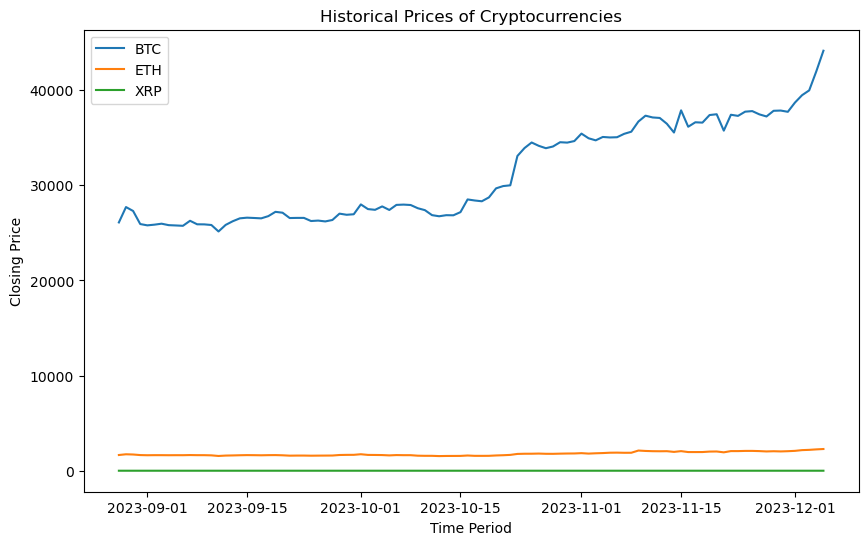

None


TypeError: DataVisualisation.plotHistoricalPrices() takes 1 positional argument but 2 were given

In [6]:
import matplotlib.pyplot as plt

class DataVisualisation:
   
    def plotHistoricalPrices(crypto_instances):
        plt.figure(figsize=(10, 6))
        for instance in crypto_instances:
            time_periods, closing_prices = instance.previousData()
            plt.plot(time_periods, closing_prices, label=instance.name)

        plt.title("Historical Prices of Cryptocurrencies")
        plt.xlabel("Time Period")
        plt.ylabel("Closing Price")
        plt.legend()
        plt.show()

   
    def plotMeanReturns(crypto_instances):
        cryptocurrencies = [instance.name for instance in crypto_instances]
        mean_returns = [instance.mean() for instance in crypto_instances]  

        plt.figure(figsize=(8, 5))
        plt.bar(cryptocurrencies, mean_returns, color=['blue', 'orange', 'green'])
        plt.title("Mean Returns Comparison")
        plt.xlabel("Cryptocurrency")
        plt.ylabel("Mean Return")
        plt.show()


# objects
btc_visual = DataVisualisation()
eth_visual = DataVisualisation()
xrp_visual = DataVisualisation()

print(DataVisualisation.plotHistoricalPrices([btc_Obj, eth_Obj, xrp_Obj]))
# Visualize historical prices
btc_visual.plotHistoricalPrices([btc_Obj])
eth_visual.plotHistoricalPrices([eth_Obj])
xrp_visual.plotHistoricalPrices([xrp_Obj])

# mean returns using bar chart
DataVisualisation.plotMeanReturns([btc_Obj, eth_Obj, xrp_Obj])


# Step 7: Save Results

# already done in step 1

#   ## Step 8 : Summarize Findings
  
  ## **Cryptocurrency Data Analysis Summary**

## Findings and Insights

### Mean Returns and Volatility
- **BTC:**
  - *Mean Return:* Indicates typical daily price change.
  - *Volatility:* Measures daily fluctuations.

- **ETH:**
  - *Mean Return:* Reflects daily performance.
  - *Volatility:* Illustrates daily price volatility.

- **XRP:**
  - *Mean Return:* Highlights daily price dynamics.
  - *Volatility:* Signifies daily price variability.

### Notable Events
- Identifying dates with the highest returns can infer influential market trends.

### Correlations
 The correlation matrix reveals relationships:
  - Positive: Tendency to move together.
  - Negative: Potential inverse relationships.

### Visualizations 
- Line charts and bar charts will provide intuitive insights into market trends and comparative performance.

### Overall Market Trends
- Combined mean returns, volatility measures, and correlation analysis offer a holistic view of market trends.
- Visualization aids in identifying patterns, trends, and outliers influencing investment decisions.

### Future Considerations
- Continuous monitoring, staying informed, and adapting strategies based on ongoing analysis are crucial for informed decision-making in the dynamic cryptocurrency market.

**Summary:**
This concise analysis, complemented by visualizations, provides valuable insights into the performance, volatility, and relationships between Bitcoin (BTC), Ethereum (ETH), and Ripple (XRP). These findings form a foundation for informed decision-making and a better understanding of the cryptocurrency market landscape.


# FINAL MAIN PROGRAM

Data for COINBASE_SPOT_BTC_USD successfully written to COINBASE_SPOT_BTC_USD_data.csv
Data for COINBASE_SPOT_ETH_USD successfully written to COINBASE_SPOT_ETH_USD_data.csv
Data for COINBASE_SPOT_XRP_USD successfully written to COINBASE_SPOT_XRP_USD_data.csv
BTC ANALYSIS:
Mean Return: 0.0053100573730441155
Median Return: 0.0011179938791458198
Standard Deviation of Returns: 0.021785429710114605
Date with Highest Return: 2023-10-23 00:00:00+00:00

ETH ANALYSIS:
Mean Return: 0.003264230934979551
Median Return: 0.002174923342018831
Standard Deviation of Returns: 0.02296277018587271
Date with Highest Return: 2023-11-09 00:00:00+00:00

XRP ANALYSIS:
Mean Return: 0.0017390136631512138
Median Return: 0.0019233857508275103
Standard Deviation of Returns: 0.024367227079024317
Date with Highest Return: 2023-11-06 00:00:00+00:00

Correlation Matrix:
          BTC       ETH       XRP
BTC  1.000000  0.775042  0.526373
ETH  0.775042  1.000000  0.532151
XRP  0.526373  0.532151  1.000000
Data for COINBAS

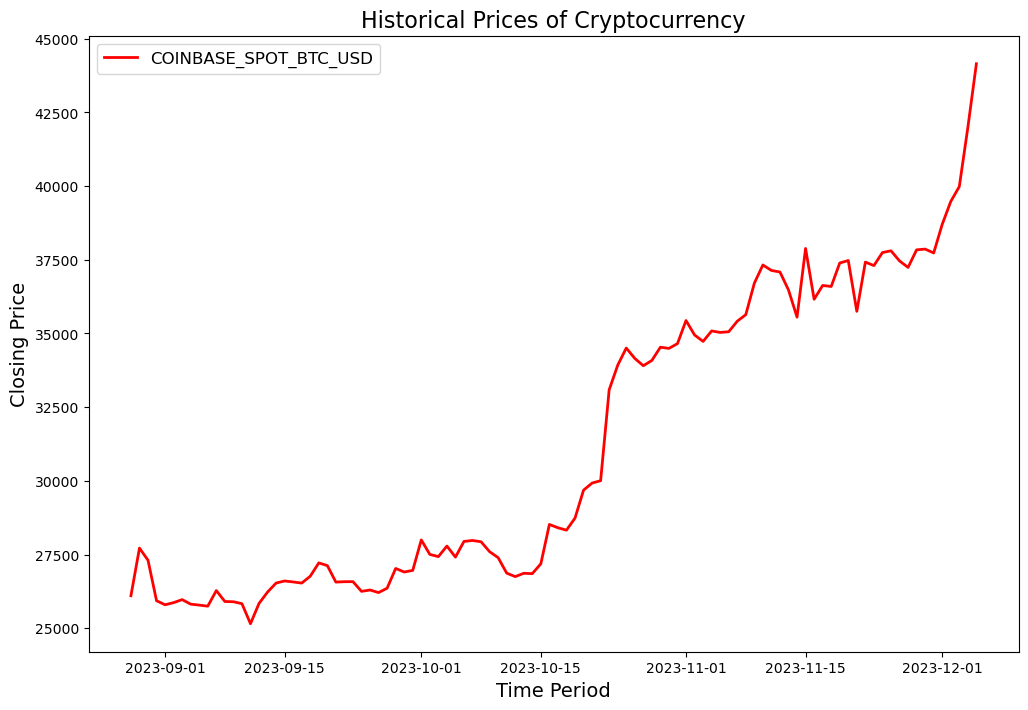

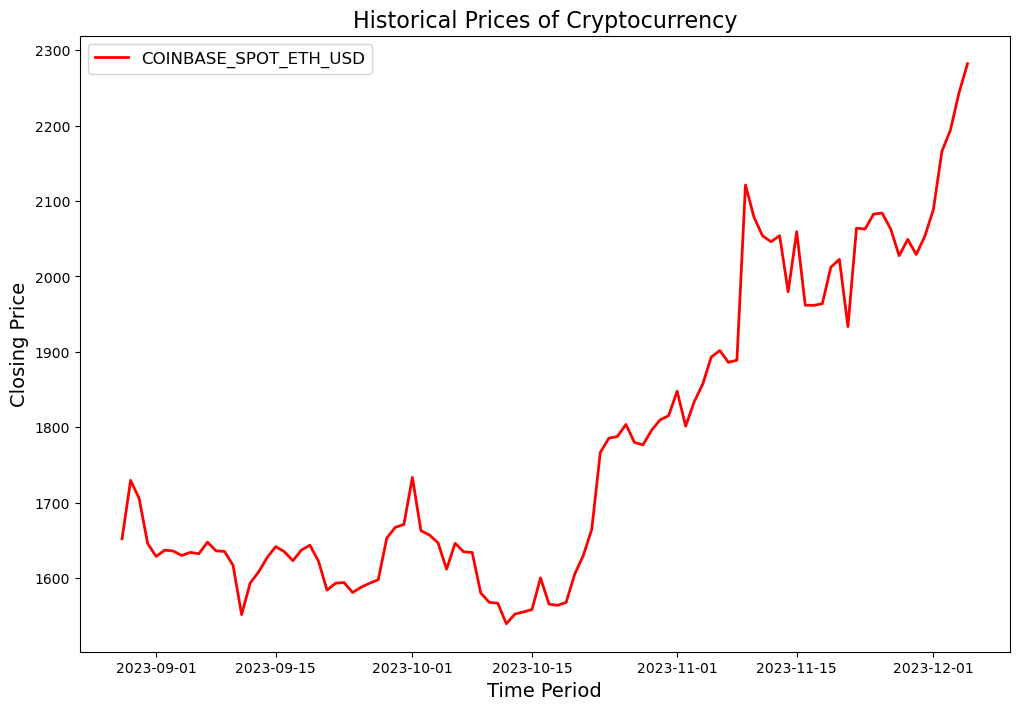

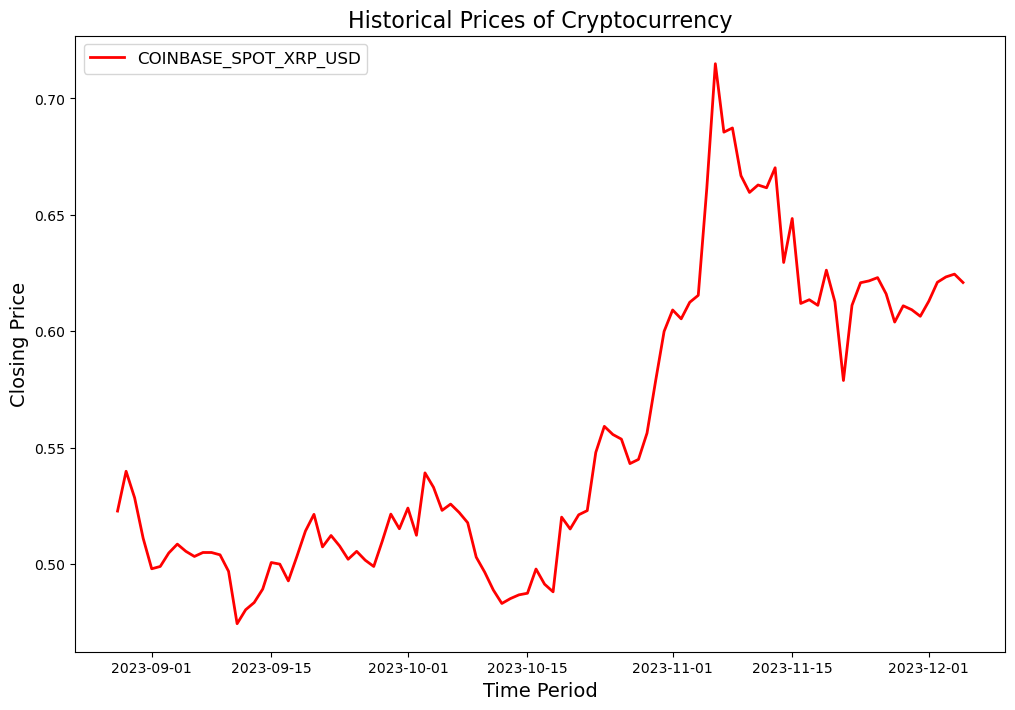

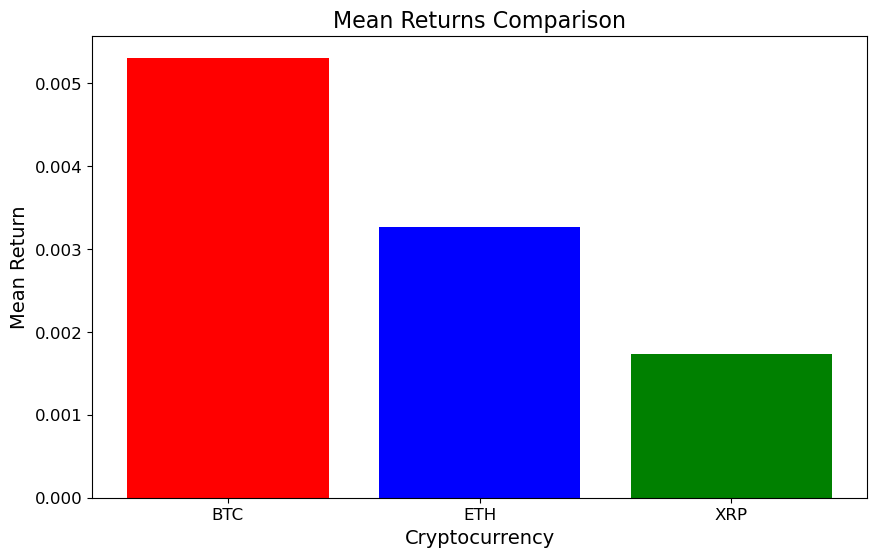

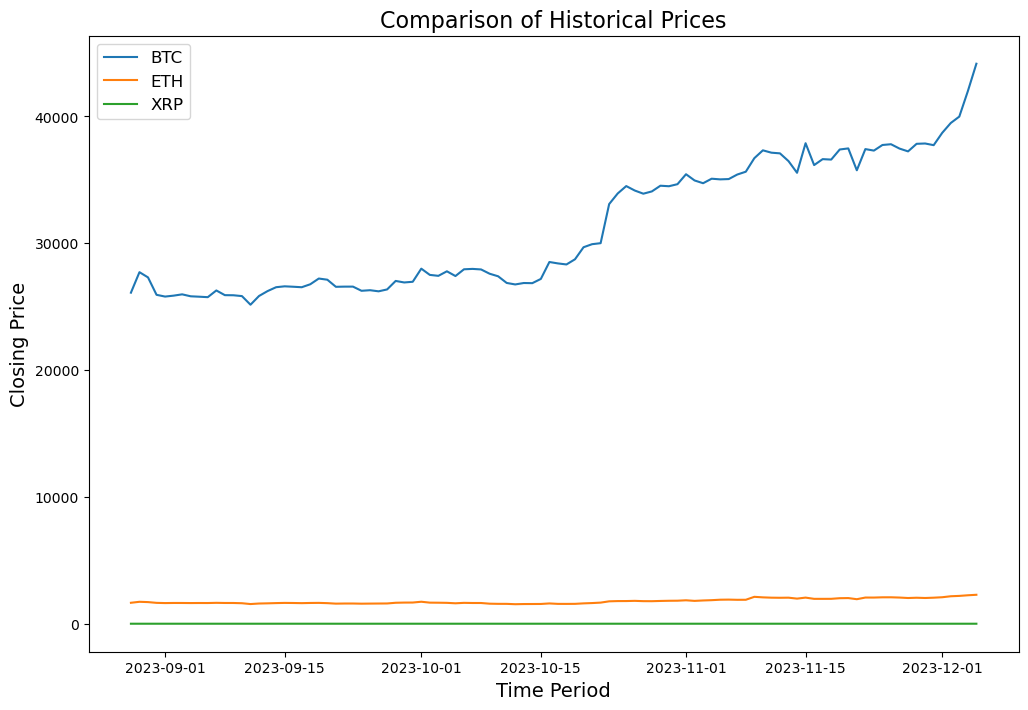

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

api_key = 'DD8C2BE5-C8E6-404E-A289-82A9EBD2D8DC'
symbols = ['COINBASE_SPOT_BTC_USD', 'COINBASE_SPOT_ETH_USD', 'COINBASE_SPOT_XRP_USD']
period_id = '1DAY'
headers = {
    'X-CoinAPI-Key': api_key
}

class DataExtraction_cleaning:
    def __init__(self, symbol_id, file_path):
        self.symbol_id = symbol_id
        self.file_path = file_path
        self.data = self.fetch_data()
        self.clean_data()

    def fetch_data(self):
        try:
            url = f'https://rest.coinapi.io/v1/ohlcv/{self.symbol_id}/history?period_id={period_id}'
            response = requests.get(url, headers=headers)

            if response.status_code == 200:
                data = response.json()
                relevant_columns = ['time_period_start', 'price_open', 'price_high', 'price_low', 'price_close', 'volume_traded']

                # Creating a DataFrame with relevant columns
                df = pd.DataFrame(data)[relevant_columns]

                # Saving to a CSV file
                df.to_csv(self.file_path, index=False)
                print(f"Data for {self.symbol_id} successfully written to {self.file_path}")

                return df
            else:
                print(f"Failed to retrieve data for {self.symbol_id}. Status code: {response.status_code}")
                return pd.DataFrame()

        except Exception as e:
            print(f"An error occurred for {self.symbol_id}: {e}")
            return pd.DataFrame()

    def clean_data(self):
        # Converting time to datetime objects
        self.data['time_period_start'] = pd.to_datetime(self.data['time_period_start'])
        self.data.ffill(inplace=True)
        self.data.bfill(inplace=True)
        numeric_cols = self.data.select_dtypes(include='number').columns
        self.data[numeric_cols] = self.data[numeric_cols].fillna(self.data[numeric_cols].mean())

    def remove_outliers(self):
        price_conditions = (self.data['price_open'] >= 0) & (self.data['price_high'] >= 0) & (self.data['price_low'] >= 0) & (self.data['price_close'] >= 0)
        self.data = self.data[price_conditions]

    def calculate_log_returns(self):
        self.data['time_period_start'] = pd.to_datetime(self.data['time_period_start'])
        self.data.fillna(method='ffill', inplace=True)
        self.data.sort_values(by='time_period_start', inplace=True)
        self.data['log_returns'] = np.log(self.data['price_close'] / self.data['price_close'].shift(1))
        self.data.to_csv(self.file_path)

    def structure_data(self):
        self.data['daily_price_change'] = self.data['price_close'] - self.data['price_open']

class DataAnalysis(DataExtraction_cleaning):
    def __init__(self, symbol_id, file_path, name):
        super().__init__(symbol_id, file_path)
        self.name = name

    def calculateReturns(self):
        return self.data['log_returns']

    def mean(self):
        return self.calculateReturns().mean()

    def median(self):
        return self.calculateReturns().median()

    def STD(self):
        return self.calculateReturns().std()

    def date_with_highest_return(self):
        max_return = self.data.loc[self.calculateReturns().idxmax(), 'time_period_start']
        return max_return

    def previousData(self):
        return self.data['time_period_start'], self.data['price_close']

    def print_analysis(self):
        print(f"{self.name} ANALYSIS:")
        print(f"Mean Return: {self.mean()}")
        print(f"Median Return: {self.median()}")
        print(f"Standard Deviation of Returns: {self.STD()}")
        print(f"Date with Highest Return: {self.date_with_highest_return()}\n")

class DataVisualisation(DataExtraction_cleaning):
    def __init__(self, symbol_id, file_path):
        super().__init__(symbol_id, file_path)

    def plotHistoricalPrices(self):
        plt.figure(figsize=(12, 8))
        
        time_periods, closing_prices = self.previousData()
        
        plt.plot(time_periods, closing_prices, label=self.symbol_id, linewidth=2, color='red')

        plt.title("Historical Prices of Cryptocurrency", fontsize=16)
        
        plt.xlabel("Time Period", fontsize=14)
        plt.ylabel("Closing Price", fontsize=14)
        
        plt.legend(fontsize=12)
        
        plt.show()

    def plotMean(self, crypto_analysis):
        cryptocurrencies = [analysis.name for analysis in crypto_analysis]
        mean_returns = [analysis.mean() for analysis in crypto_analysis]

        plt.figure(figsize=(10, 6))
        
        plt.bar(cryptocurrencies, mean_returns, color=['red', 'blue', 'green'])
        
        plt.title("Mean Returns Comparison", fontsize=16)
        plt.xlabel("Cryptocurrency", fontsize=14)
        plt.ylabel("Mean Return", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        plt.show()

    def compare_prices_line_chart(self, obj):
        plt.figure(figsize=(12, 8))

        for analysis in obj:
            time_periods, closing_prices = analysis.previousData()
            plt.plot(time_periods, closing_prices, label=analysis.name)

        plt.title("Comparison of Historical Prices", fontsize=16)
        plt.xlabel("Time Period", fontsize=14)
        plt.ylabel("Closing Price", fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

    def previousData(self):
        return self.data['time_period_start'], self.data['price_close']

# Create objects for each cryptocurrency
btc_obj = DataAnalysis('COINBASE_SPOT_BTC_USD', 'COINBASE_SPOT_BTC_USD_data.csv', 'BTC')
eth_obj = DataAnalysis('COINBASE_SPOT_ETH_USD', 'COINBASE_SPOT_ETH_USD_data.csv', 'ETH')
xrp_obj = DataAnalysis('COINBASE_SPOT_XRP_USD', 'COINBASE_SPOT_XRP_USD_data.csv', 'XRP')

btc_obj.calculate_log_returns()
eth_obj.calculate_log_returns()
xrp_obj.calculate_log_returns()

# Analysis for each cryptocurrency
btc_obj.print_analysis()
eth_obj.print_analysis()
xrp_obj.print_analysis()

# Printing correlation matrix
correlation_matrix = pd.DataFrame({
    'BTC': btc_obj.calculateReturns(),
    'ETH': eth_obj.calculateReturns(),
    'XRP': xrp_obj.calculateReturns()
})

print("Correlation Matrix:")
print(correlation_matrix.corr())

# Creating objects for visualization
btc_visual = DataVisualisation('COINBASE_SPOT_BTC_USD', 'COINBASE_SPOT_BTC_USD_data.csv')
eth_visual = DataVisualisation('COINBASE_SPOT_ETH_USD', 'COINBASE_SPOT_ETH_USD_data.csv')
xrp_visual = DataVisualisation('COINBASE_SPOT_XRP_USD', 'COINBASE_SPOT_XRP_USD_data.csv')

crypto_obj = [btc_obj, eth_obj, xrp_obj]

# Visualize historical prices
btc_visual.plotHistoricalPrices()
eth_visual.plotHistoricalPrices()
xrp_visual.plotHistoricalPrices()

# Mean returns using bar chart
btc_visual.plotMean(crypto_obj)
btc_visual.compare_prices_line_chart(crypto_obj)
